In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import silhouette_score
from IPython.display import clear_output

# Load the CSV File
file_path = "tournament_decks.csv"
data = pd.read_csv(file_path)
data

,tournamenturl,playername,mainpokemon,secondarypokemon,deckurl,rank,cards
0,https://limitlesstcg.com/tournaments/jp/1839,1-3,milotic,farigiraf,https://limitlesstcg.com/decks/list/jp/27337,1,P#Feebas#3#https://limitlesstcg.com/cards/SSP/...
1,https://limitlesstcg.com/tournaments/jp/1839,だいくん。,raging-bolt,ogerpon,https://limitlesstcg.com/decks/list/jp/27338,2,P#Raging Bolt ex#4#https://limitlesstcg.com/ca...
2,https://limitlesstcg.com/tournaments/jp/1839,omochikun,xatu,espathra,https://limitlesstcg.com/decks/list/jp/27339,3,P#Natu#3#https://limitlesstcg.com/cards/PAR/71...
3,https://limitlesstcg.com/tournaments/jp/1839,セラ,raging-bolt,ogerpon,https://limitlesstcg.com/decks/list/jp/27340,4,P#Raging Bolt ex#4#https://limitlesstcg.com/ca...
4,https://limitlesstcg.com/tournaments/jp/1839,伸び代のペリ,dragapult,NaN,https://limitlesstcg.com/decks/list/jp/27341,5,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...
...,...,...,...,...,...,...,...
8169,https://limitlesstcg.com/tournaments/jp/2358,ちょこ,garchomp,roserade,https://limitlesstcg.com/decks/list/jp/35405,12,P#Cynthia's Gible#4#https://limitlesstcg.com/c...
8170,https://limitlesstcg.com/tournaments/jp/2358,ゴリラ,dragapult,dusknoir,https://limitlesstcg.com/decks/list/jp/35406,13,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...
8171,https://limitlesstcg.com/tournaments/jp/2358,じりつくん,dragapult,dusknoir,https://limitlesstcg.com/decks/list/jp/35407,14,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...
8172,https://limitlesstcg.com/tournaments/jp/2358,ポッチャマ,charizard,pidgeot,https://limitlesstcg.com/decks/list/jp/35408,15,P#Charmander#3#https://limitlesstcg.com/cards/...


In [2]:
# Parse the "cards" column to extract card links, counts, and types as features
def parse_cards_with_types(cards):
    card_list = cards.split('|')
    card_features = {"p": {}, "t": {}, "e": {}}
    for card in card_list:
        parts = card.split('#')
        if len(parts) >= 3:
            card_type = parts[0].lower() # Extract card type (e.g., "pokemon", "trainer", "energy")
            card_link = parts[3]         # Use the card link as the feature
            card_count = int(parts[2])   # Use the card count as the value
            if card_type in card_features:
                card_features[card_type][card_link] = card_count
    return card_features

card_features_with_types = data['cards'].apply(parse_cards_with_types)
card_features_with_types

0       {'p': {'https://limitlesstcg.com/cards/SSP/41'...
1       {'p': {'https://limitlesstcg.com/cards/TEF/123...
2       {'p': {'https://limitlesstcg.com/cards/PAR/71'...
3       {'p': {'https://limitlesstcg.com/cards/TEF/123...
4       {'p': {'https://limitlesstcg.com/cards/TWM/128...
                              ...                        
8169    {'p': {'https://limitlesstcg.com/cards/jp/SV9a...
8170    {'p': {'https://limitlesstcg.com/cards/TWM/128...
8171    {'p': {'https://limitlesstcg.com/cards/TWM/128...
8172    {'p': {'https://limitlesstcg.com/cards/MEW/4':...
8173    {'p': {'https://limitlesstcg.com/cards/SCR/106...
Name: cards, Length: 8174, dtype: object

In [3]:
# Separate features by card type
pokemon_features = card_features_with_types.apply(lambda x: x['p'])
trainer_features = card_features_with_types.apply(lambda x: x['t'])
energy_features = card_features_with_types.apply(lambda x: x['e'])

# Convert each card type into a feature matrix
vectorizer = DictVectorizer(sparse=True)
pokemon_matrix = vectorizer.fit_transform(pokemon_features)
trainer_matrix = vectorizer.fit_transform(trainer_features)
energy_matrix = vectorizer.fit_transform(energy_features)

# Weight the features by card type (adjust weights as needed)
pokemon_weight = 1.0
trainer_weight = 0.5
energy_weight = 0.2

# Combine the weighted feature matrices
X_combined = hstack([
    pokemon_matrix * pokemon_weight,
    trainer_matrix * trainer_weight,
    energy_matrix * energy_weight
])

# Normalize the combined feature matrix
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_combined)
X_scaled

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 232454 stored elements and shape (8174, 798)>

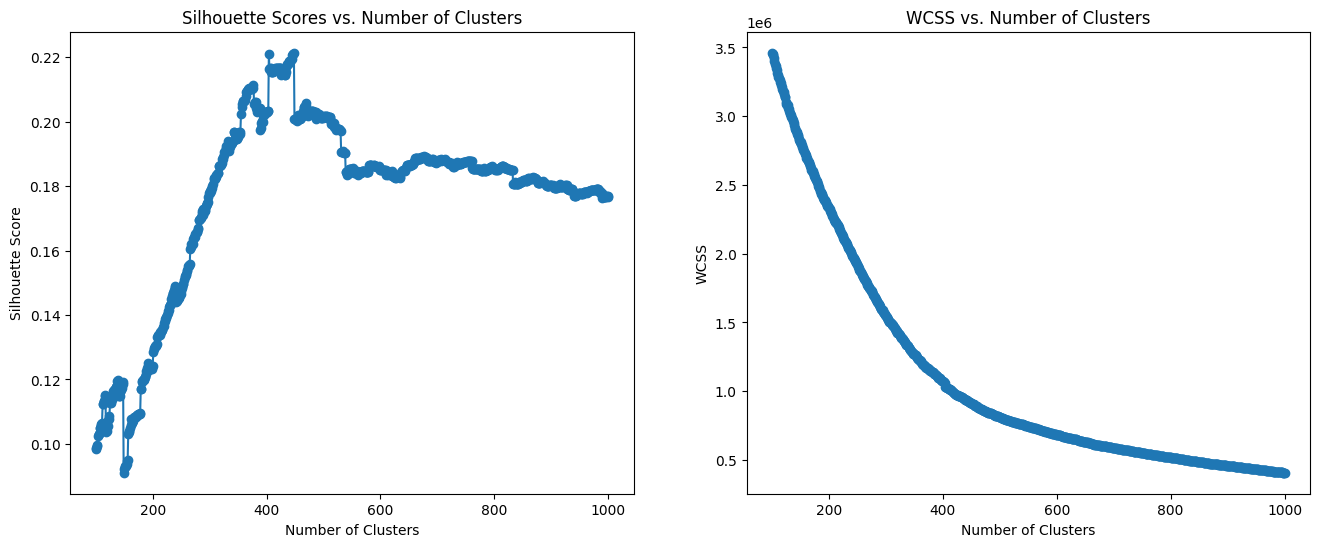

In [8]:
# Find the optimal number of clusters
silhouette_scores = []
wcss = []
cluster_range = range(100, 1001)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
    wcss.append(kmeans.inertia_)

    if n_clusters % 10 == 0:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Plot silhouette scores
        axes[0].plot(range(100, n_clusters + 1), silhouette_scores, marker='o')
        axes[0].set_title('Silhouette Scores vs. Number of Clusters')
        axes[0].set_xlabel('Number of Clusters')
        axes[0].set_ylabel('Silhouette Score')

        # Plot WCSS
        axes[1].plot(range(100, n_clusters + 1), wcss, marker='o')
        axes[1].set_title('WCSS vs. Number of Clusters')
        axes[1].set_xlabel('Number of Clusters')
        axes[1].set_ylabel('WCSS')

        # Show the plots
        plt.show()


In [11]:
# index of max silhouette score
silhouette_scores.index(max(silhouette_scores)) + 100

448

In [12]:
num_clusters = 448
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(X_scaled)

In [13]:
# Calculate cluster statistics
cluster_stats = data.groupby('cluster').agg(
    cluster_size=('cluster', 'size'),  # Number of decks in each cluster
    mean_rank=('rank', 'mean'),       # Average rank of decks in each cluster
    min_rank=('rank', 'min'),         # Minimum rank in each cluster
    max_rank=('rank', 'max')          # Maximum rank in each cluster
).reset_index()

# Print cluster statistics
cluster_stats

,cluster,cluster_size,mean_rank,min_rank,max_rank
0,0,49,8.918367,1,16
1,1,73,7.780822,1,16
2,2,73,8.657534,1,16
3,3,9,8.111111,1,16
4,4,46,9.652174,2,16
...,...,...,...,...,...
443,443,2,5.500000,2,9
444,444,89,8.101124,1,16
445,445,5,11.200000,4,14
446,446,1,16.000000,16,16


In [37]:
# Calculate the median rank for each cluster
cluster_mean_rank = data.groupby('cluster').agg(
    mean_rank=('rank', 'mean'),  # Mean rank of decks in each cluster
    cluster_size=('cluster', 'size'), # Number of decks in each cluster
    main_pokemon=('mainpokemon', lambda x: x.mode()[0] if not x.mode().empty else None),  # Most common main Pokemon
    secondary_pokemon=('secondarypokemon', lambda x: x.mode()[0] if not x.mode().empty else None),  # Most common secondary Pokemon
).reset_index()

# Sort clusters by median rank
cluster_mean_rank = cluster_mean_rank.sort_values(by='mean_rank')
pd.options.display.max_rows = None
cluster_mean_rank[(cluster_mean_rank['cluster_size'] > 30)].head(20)
# cluster_mean_rank[(cluster_mean_rank['main_pokemon'] == 'charizard') & (cluster_mean_rank['secondary_pokemon'] == 'dudunsparce')].head(20)


,cluster,mean_rank,cluster_size,main_pokemon,secondary_pokemon
427,427,7.128205,39,dragapult,xatu
217,217,7.480000,50,typhlosion,typhlosion
349,349,7.574074,54,dragapult,dusknoir
326,326,7.587629,97,ogerpon,raging-bolt
407,407,7.589744,39,charizard,dudunsparce
36,36,7.764706,34,froslass,espathra
1,1,7.780822,73,gardevoir,munkidori
361,361,7.784314,51,gardevoir,munkidori
167,167,7.825806,310,ogerpon,raging-bolt
18,18,7.864865,74,noctowl,charizard


In [39]:
# Sort values by rank then by tournamenturl
data[data['cluster'] == 349].sort_values(by=['rank', 'tournamenturl'], ascending=[True, False])

,tournamenturl,playername,mainpokemon,secondarypokemon,deckurl,rank,cards,cluster
8078,https://limitlesstcg.com/tournaments/jp/2353,MMMT,dragapult,dusknoir,https://limitlesstcg.com/decks/list/jp/35316,1,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...,349
8047,https://limitlesstcg.com/tournaments/jp/2351,へるにあ,dragapult,NaN,https://limitlesstcg.com/decks/list/jp/35285,1,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...,349
7952,https://limitlesstcg.com/tournaments/jp/2345,ヒデタラメ,dragapult,munkidori,https://limitlesstcg.com/decks/list/jp/35191,1,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...,349
7936,https://limitlesstcg.com/tournaments/jp/2344,はく,dragapult,NaN,https://limitlesstcg.com/decks/list/jp/35175,1,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...,349
7761,https://limitlesstcg.com/tournaments/jp/2333,タツベー,dragapult,NaN,https://limitlesstcg.com/decks/list/jp/35000,1,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...,349
7730,https://limitlesstcg.com/tournaments/jp/2331,サクサン,dragapult,dusknoir,https://limitlesstcg.com/decks/list/jp/34969,1,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...,349
8063,https://limitlesstcg.com/tournaments/jp/2352,ハセガワ,dragapult,dusknoir,https://limitlesstcg.com/decks/list/jp/35301,2,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...,349
8016,https://limitlesstcg.com/tournaments/jp/2349,うたは,dragapult,dusknoir,https://limitlesstcg.com/decks/list/jp/35255,2,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...,349
7953,https://limitlesstcg.com/tournaments/jp/2345,カツオ,dragapult,dusknoir,https://limitlesstcg.com/decks/list/jp/35192,2,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...,349
7684,https://limitlesstcg.com/tournaments/jp/2328,ヨネタクの弟子,dragapult,NaN,https://limitlesstcg.com/decks/list/jp/34923,2,P#Dreepy#4#https://limitlesstcg.com/cards/TWM/...,349
